In [4]:
%cd C:\mimic-iv-2.2\mimic-iv-2.2\hosp

C:\mimic-iv-2.2\mimic-iv-2.2\hosp


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 파일간 병합 및 전처리

## d_icd_diagnoses파일 

In [6]:
df_d_icd_diagnoses = pd.read_csv('d_icd_diagnoses.csv')
df_d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     109775 non-null  object
 1   icd_version  109775 non-null  int64 
 2   long_title   109775 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [7]:
for i in df_d_icd_diagnoses.columns:
    print(i,df_d_icd_diagnoses[i].min(),df_d_icd_diagnoses[i].max())

icd_code 0010 Z9989
icd_version 9 10
long_title "Light-for-dates" with signs of fetal malnutrition, 1,000-1,249 grams von Gierke disease


In [8]:
# int32를 int16으로 변환
df_d_icd_diagnoses['icd_version'] = df_d_icd_diagnoses['icd_version'].astype('int16')
df_d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     109775 non-null  object
 1   icd_version  109775 non-null  int16 
 2   long_title   109775 non-null  object
dtypes: int16(1), object(2)
memory usage: 1.9+ MB


In [9]:
df_d_icd_diagnoses.drop(['icd_version','long_title'],axis=1,inplace =True)
df_d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   icd_code  109775 non-null  object
dtypes: object(1)
memory usage: 857.7+ KB


## diagnoses_icd파일

In [10]:
df_diagnoses_icd = pd.read_csv("diagnoses_icd.csv")
df_diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


## 고혈압이면서 암걸린 환자들만 추출

In [11]:
# 고혈압 진단 코드 정규식
high_bp_regex = r'^I1[0-5]$|^401'

#암 진단 코드 정규식  
#ICD-9 코드 분류 (140-239)
#ICD-10 코드 분류 (C00-C96, D00-D09)
cancer_regex = r'^(D(0[0-9])|C([0-8][0-9]|9[0-6])|(1[4-9][0-9]|2[0-3][0-9])).*'


# 암 진단 코드 추출
cancer_df = df_diagnoses_icd[df_diagnoses_icd['icd_code'].str.match(cancer_regex)]

# 암 진단을 받은 환자 ID 추출
cancer_patient_ids = cancer_df['subject_id'].unique()

# 암 진단을 받은 환자들의 데이터 추출 
#병합
cancer_diagnoses_merged = pd.merge(df_diagnoses_icd, df_d_icd_diagnoses, on=['icd_code'])
cancer_patients_data = cancer_diagnoses_merged[cancer_diagnoses_merged['subject_id'].isin(cancer_patient_ids)]



# 암 및 고혈압을 동시에 가진 환자들의 데이터 추출 (첫 번째 진단만 포함)
cancer_high_bp_ids = cancer_patients_data[cancer_patients_data['icd_code'].str.match(high_bp_regex)]['subject_id'].unique()
cancer_high_bp_df = cancer_diagnoses_merged[(cancer_diagnoses_merged['subject_id'].isin(cancer_high_bp_ids)) & 
                                            (cancer_diagnoses_merged['seq_num'] == 1) & 
                                            (cancer_diagnoses_merged['icd_code'].str.match(cancer_regex))]

cancer_high_bp_df

,subject_id,hadm_id,seq_num,icd_code,icd_version
393337,10071129,25200387,1,1890,9
393339,10094971,20200109,1,1890,9
393351,10171405,23985269,1,1890,9
393356,10171405,29677692,1,1890,9
393364,10322775,24742385,1,1890,9
...,...,...,...,...,...
4859732,19128927,28814179,1,C44692,10
4859827,19282415,28695316,1,C004,10
4859828,19290501,28187167,1,C8468,10
4860174,19851929,29152819,1,1643,9


In [12]:
cancer_high_bp_df.drop(['icd_version','seq_num'],axis=1, inplace=True)

C:\Users\TS\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
cancer_high_bp_df.reset_index()

,index,subject_id,hadm_id,icd_code
0,393337,10071129,25200387,1890
1,393339,10094971,20200109,1890
2,393351,10171405,23985269,1890
3,393356,10171405,29677692,1890
4,393364,10322775,24742385,1890
...,...,...,...,...
13238,4859732,19128927,28814179,C44692
13239,4859827,19282415,28695316,C004
13240,4859828,19290501,28187167,C8468
13241,4860174,19851929,29152819,1643


In [14]:
cancer_high_bp_df

,subject_id,hadm_id,icd_code
393337,10071129,25200387,1890
393339,10094971,20200109,1890
393351,10171405,23985269,1890
393356,10171405,29677692,1890
393364,10322775,24742385,1890
...,...,...,...
4859732,19128927,28814179,C44692
4859827,19282415,28695316,C004
4859828,19290501,28187167,C8468
4860174,19851929,29152819,1643


In [14]:
cancer_high_bp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13243 entries, 393337 to 4860191
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  13243 non-null  int64 
 1   hadm_id     13243 non-null  int64 
 2   icd_code    13243 non-null  object
dtypes: int64(2), object(1)
memory usage: 413.8+ KB


In [15]:
for i in cancer_high_bp_df.columns:
    print(i,cancer_high_bp_df[i].min(),cancer_high_bp_df[i].max())

subject_id 10001401 19999784
hadm_id 20000808 29998978
icd_code 1410 D0919


In [16]:
cancer_high_bp_df['subject_id'] = cancer_high_bp_df['subject_id'].astype('int32')
cancer_high_bp_df['hadm_id'] = cancer_high_bp_df['hadm_id'].astype('int32')

C:\Users\TS\AppData\Local\Temp\ipykernel_16264\3501051655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_high_bp_df['subject_id'] = cancer_high_bp_df['subject_id'].astype('int32')
C:\Users\TS\AppData\Local\Temp\ipykernel_16264\3501051655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_high_bp_df['hadm_id'] = cancer_high_bp_df['hadm_id'].astype('int32')


In [17]:
cancer_high_bp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13243 entries, 393337 to 4860191
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  13243 non-null  int32 
 1   hadm_id     13243 non-null  int32 
 2   icd_code    13243 non-null  object
dtypes: int32(2), object(1)
memory usage: 310.4+ KB


In [17]:
# subject_id로 그룹화하고 각 그룹에서 hadm_id가 가장 작은 행 선택
result = cancer_high_bp_df.loc[cancer_high_bp_df.groupby('subject_id')['hadm_id'].idxmin()]

# 필요시 인덱스 리셋
result.reset_index(drop=True, inplace=True)

In [19]:
result

,subject_id,hadm_id,icd_code
0,10001401,21544441,C675
1,10001877,25679292,2252
2,10002155,20345487,1628
3,10002348,22725460,C7931
4,10003400,20214994,1543
...,...,...,...
9183,19996783,22140408,C259
9184,19997538,22701415,C20
9185,19999204,29046609,C220
9186,19999287,22997012,1629


## patients 파일

In [18]:
df_patients = pd.read_csv("patients.csv")

In [21]:
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


In [22]:
df_patients

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN
299708,19999829,F,28,2186,2008 - 2010,NaN
299709,19999840,M,58,2164,2008 - 2010,2164-09-17
299710,19999914,F,49,2158,2017 - 2019,NaN


In [19]:
merge2 = pd.merge(result,df_patients, on=['subject_id'])
merge2

,subject_id,hadm_id,icd_code,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10001401,21544441,C675,F,89,2131,2014 - 2016,NaN
1,10001877,25679292,2252,M,89,2149,2008 - 2010,NaN
2,10002155,20345487,1628,F,80,2128,2008 - 2010,2131-03-10
3,10002348,22725460,C7931,F,77,2112,2017 - 2019,NaN
4,10003400,20214994,1543,F,72,2134,2011 - 2013,2137-09-02
...,...,...,...,...,...,...,...,...
9183,19996783,22140408,C259,M,89,2188,2017 - 2019,2188-05-21
9184,19997538,22701415,C20,M,53,2168,2017 - 2019,NaN
9185,19999204,29046609,C220,M,61,2146,2017 - 2019,2146-08-29
9186,19999287,22997012,1629,F,71,2191,2008 - 2010,2197-09-02


## admissions파일

In [20]:
df_admission = pd.read_csv("admissions.csv")
merge2_admission = pd.merge(merge2,df_admission, on=['subject_id','hadm_id'])
merge2_admission

,subject_id,hadm_id,icd_code,gender,anchor_age,anchor_year,anchor_year_group,dod,admittime,dischtime,...,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10001401,21544441,C675,F,89,2131,2014 - 2016,NaN,2131-06-04 00:00:00,2131-06-15 16:10:00,...,P872K3,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0
1,10001877,25679292,2252,M,89,2149,2008 - 2010,NaN,2149-05-21 15:53:00,2149-05-27 13:35:00,...,P47KFL,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,MARRIED,WHITE,2149-05-21 10:58:00,2149-05-21 17:15:00,0
2,10002155,20345487,1628,F,80,2128,2008 - 2010,2131-03-10,2131-03-09 20:33:00,2131-03-10 01:55:00,...,P80515,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2131-03-09 19:14:00,2131-03-09 21:33:00,1
3,10002348,22725460,C7931,F,77,2112,2017 - 2019,NaN,2112-11-30 22:22:00,2112-12-10 17:56:00,...,P35WT5,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0
4,10003400,20214994,1543,F,72,2134,2011 - 2013,2137-09-02,2137-02-24 10:00:00,2137-03-19 15:45:00,...,P60ZCO,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9183,19996783,22140408,C259,M,89,2188,2017 - 2019,2188-05-21,2188-04-22 14:52:00,2188-04-24 04:41:00,...,P878WT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,ASIAN - CHINESE,2188-04-22 08:36:00,2188-04-22 19:49:00,0
9184,19997538,22701415,C20,M,53,2168,2017 - 2019,NaN,2168-05-01 00:00:00,2168-05-22 17:59:00,...,P68URZ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
9185,19999204,29046609,C220,M,61,2146,2017 - 2019,2146-08-29,2146-05-30 16:43:00,2146-06-08 20:20:00,...,P553JT,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,2146-05-30 14:10:00,2146-05-30 20:09:00,0
9186,19999287,22997012,1629,F,71,2191,2008 - 2010,2197-09-02,2197-07-26 03:29:00,2197-07-31 14:00:00,...,P44WVR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,2197-07-26 02:51:00,2197-07-26 05:00:00,0


In [21]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2131          89
1         2149          89
2         2128          80
3         2112          77
4         2134          72
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


C:\Users\TS\AppData\Local\Temp\ipykernel_16264\4117411835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']
C:\Users\TS\AppData\Local\Temp\ipykernel_16264\4117411835.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']


In [22]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2128          80
1         2112          77
2         2134          72
3         2196          47
4         2138          60
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


In [23]:
merge2_admission = merge2_admission[['subject_id','hadm_id','admit_age','gender','language','marital_status','race','hospital_expire_flag']]
merge2_admission

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0
2,10003400,20214994,75,F,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
3,10004235,25970245,47,M,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0
4,10005024,25023471,60,M,ENGLISH,SINGLE,UNKNOWN,1
...,...,...,...,...,...,...,...,...
8954,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
8955,19997538,22701415,53,M,ENGLISH,MARRIED,WHITE,0
8956,19999204,29046609,61,M,ENGLISH,SINGLE,WHITE,0
8957,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0


In [24]:
df_data = merge2_admission
df_data.info()
df_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8959 entries, 0 to 8958
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            8959 non-null   int32 
 1   hadm_id               8959 non-null   int32 
 2   admit_age             8959 non-null   int64 
 3   gender                8959 non-null   object
 4   language              8959 non-null   object
 5   marital_status        8836 non-null   object
 6   race                  8959 non-null   object
 7   hospital_expire_flag  8959 non-null   int64 
dtypes: int32(2), int64(2), object(4)
memory usage: 490.1+ KB


,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0
2,10003400,20214994,75,F,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
3,10004235,25970245,47,M,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0
4,10005024,25023471,60,M,ENGLISH,SINGLE,UNKNOWN,1


In [25]:
# 카테고리 열로 변환
df_data['gender'] = df_data['gender'].astype('category')
df_data['language'] = df_data['language'].astype('category')
df_data['marital_status'] = df_data['marital_status'].astype('category')
df_data['race'] = df_data['race'].astype('category')

# # admit_age를 uint8으로 변환
df_data['admit_age'] = pd.to_numeric(df_data['admit_age'], downcast='unsigned')

## omr 파일 

In [26]:
omr= pd.read_csv('omr.csv')
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [27]:
# 피벗 테이블 생성
pivot_df = omr.pivot_table(index=['subject_id', 'chartdate'], 
                           columns='result_name', 
                           values='result_value', 
                           aggfunc='first').reset_index()

In [28]:
pivot_df = pivot_df[['subject_id','BMI (kg/m2)','Blood Pressure', 'Height (Inches)','Weight (Lbs)']]
pivot_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268174 entries, 0 to 2268173
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   subject_id       2268174 non-null  int64 
 1   BMI (kg/m2)      1643579 non-null  object
 2   Blood Pressure   2078024 non-null  object
 3   Height (Inches)  698238 non-null   object
 4   Weight (Lbs)     1773967 non-null  object
dtypes: int64(1), object(4)
memory usage: 86.5+ MB


In [29]:
pivot_df = pivot_df.dropna()

In [30]:
# Blood Pressure를 Systolic과 Diastolic으로 분리
pivot_df[['Systolic', 'Diastolic']] = pivot_df['Blood Pressure'].str.split('/', expand=True)
pivot_df['Systolic'] = pd.to_numeric(pivot_df['Systolic'])
pivot_df['Diastolic'] = pd.to_numeric(pivot_df['Diastolic'])

pivot_df = pivot_df.drop(['Blood Pressure'],axis=1)

In [31]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606424 entries, 4 to 2268159
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   subject_id       606424 non-null  int64 
 1   BMI (kg/m2)      606424 non-null  object
 2   Height (Inches)  606424 non-null  object
 3   Weight (Lbs)     606424 non-null  object
 4   Systolic         606424 non-null  int64 
 5   Diastolic        606424 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 32.4+ MB


In [32]:
pivot_df['BMI (kg/m2)'] = pivot_df['BMI (kg/m2)'].astype(float)
pivot_df['Height (Inches)'] = pivot_df['Height (Inches)'].astype(float)
pivot_df['Weight (Lbs)'] = pivot_df['Weight (Lbs)'].astype(float)

In [33]:
df_grouped = pivot_df.groupby('subject_id').mean()
df_grouped

result_name,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
subject_id,,,,,
10000032,18.900000,60.000000,97.000000,100.000000,60.000000
10000117,18.671429,64.571429,110.707143,112.357143,72.357143
10000635,33.200000,67.833333,217.033333,146.333333,78.666667
10000719,37.000000,67.000000,236.000000,144.000000,88.000000
10000826,20.500000,68.000000,135.000000,100.000000,64.000000
...,...,...,...,...,...
19999303,21.600000,67.375000,139.666667,152.166667,89.166667
19999442,26.300000,75.500000,213.000000,122.000000,82.000000
19999464,24.430000,62.087500,133.970000,115.800000,72.150000


In [34]:
df_grouped

result_name,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
subject_id,,,,,
10000032,18.900000,60.000000,97.000000,100.000000,60.000000
10000117,18.671429,64.571429,110.707143,112.357143,72.357143
10000635,33.200000,67.833333,217.033333,146.333333,78.666667
10000719,37.000000,67.000000,236.000000,144.000000,88.000000
10000826,20.500000,68.000000,135.000000,100.000000,64.000000
...,...,...,...,...,...
19999303,21.600000,67.375000,139.666667,152.166667,89.166667
19999442,26.300000,75.500000,213.000000,122.000000,82.000000
19999464,24.430000,62.087500,133.970000,115.800000,72.150000


## df_grouped과 df_data 병합

In [35]:
df_data

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0
2,10003400,20214994,75,F,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
3,10004235,25970245,47,M,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0
4,10005024,25023471,60,M,ENGLISH,SINGLE,UNKNOWN,1
...,...,...,...,...,...,...,...,...
8954,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0
8955,19997538,22701415,53,M,ENGLISH,MARRIED,WHITE,0
8956,19999204,29046609,61,M,ENGLISH,SINGLE,WHITE,0
8957,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0


In [36]:
df_data= pd.merge(df_data,df_grouped, on=['subject_id'])

In [37]:
df_data

,subject_id,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
0,10002155,20345487,83,F,ENGLISH,MARRIED,WHITE,1,21.784211,59.552632,109.863158,131.526316,61.105263
1,10002348,22725460,77,F,ENGLISH,SINGLE,WHITE,0,17.200000,61.500000,92.533333,103.000000,60.000000
2,10005348,29496232,76,M,ENGLISH,MARRIED,WHITE,0,20.633333,72.083333,152.566667,124.000000,72.000000
3,10006029,25426298,73,M,ENGLISH,MARRIED,WHITE,0,29.433333,65.788462,180.989744,129.820513,65.589744
4,10006431,25086012,67,F,?,MARRIED,WHITE,0,21.368421,62.210526,117.631579,128.526316,66.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,19992507,21449935,66,F,ENGLISH,DIVORCED,WHITE,0,47.517054,65.043798,285.954264,131.914729,72.085271
6956,19994588,28352743,78,F,?,SINGLE,ASIAN - SOUTH EAST ASIAN,0,24.758824,57.455882,116.364706,127.352941,62.470588
6957,19995127,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,24.669231,72.903846,186.530769,112.769231,66.461538
6958,19999287,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,32.388889,65.972222,200.411111,127.555556,70.555556


## d_labitems

In [38]:
d_labitems= pd.read_csv('d_labitems.csv')
d_labitems.head()
d_labitems.drop(['fluid','category'],axis=1,inplace=True)

In [39]:
d_labitems

,itemid,label
0,50801,Alveolar-arterial Gradient
1,50802,Base Excess
2,50803,"Calculated Bicarbonate, Whole Blood"
3,50804,Calculated Total CO2
4,50805,Carboxyhemoglobin
...,...,...
1617,53150,Anti Hbs
1618,53151,Anti-la
1619,53152,HIV FINAL
1620,53153,HIV Screen


## labevents

In [3]:
columns_to_read = ['subject_id', 'itemid', 'charttime', 'valuenum']
labevents = pd.read_csv('labevents.csv',usecols=columns_to_read)

# 데이터 출력
labevents.head()

,subject_id,itemid,charttime,valuenum
0,10000032,51237,2180-03-23 11:51:00,1.4
1,10000032,51274,2180-03-23 11:51:00,15.1
2,10000032,50853,2180-03-23 11:51:00,15.0
3,10000032,50861,2180-03-23 11:51:00,102.0
4,10000032,50862,2180-03-23 11:51:00,3.3


## d_labitems, labevents 병합

In [40]:
lab = pd.merge(labevents,d_labitems,on = 'itemid')

## 소듐과 포타슘만 가져오기

In [41]:
# 각 subject_id별 첫 번째 Sodium 기록과 첫 번째 Potassium 기록 찾기
first_sodium = lab[lab['label'] == 'Sodium'].sort_values(by=['subject_id', 'charttime']).groupby('subject_id').first().reset_index()
first_potassium = lab[lab['label'] == 'Potassium'].sort_values(by=['subject_id', 'charttime']).groupby('subject_id').first().reset_index()

# 결과 병합
first_records = pd.merge(first_sodium, first_potassium, on='subject_id', suffixes=('_Sodium', '_Potassium'))

# 결과 출력
first_records = first_records[['subject_id', 'valuenum_Sodium', 'valuenum_Potassium']]
first_records

,subject_id,valuenum_Sodium,valuenum_Potassium
0,10000032,136.0,3.7
1,10000048,141.0,4.0
2,10000084,132.0,5.8
3,10000108,141.0,3.5
4,10000117,138.0,4.0
...,...,...,...
233187,19999784,143.0,4.9
233188,19999828,136.0,4.7
233189,19999829,138.0,4.4
233190,19999840,138.0,3.6


In [42]:
first_records[['valuenum_Sodium', 'valuenum_Potassium']] = first_records[['valuenum_Sodium', 'valuenum_Potassium']].astype('float16')

In [ ]:
first_records.info()

##  first_records와  df_data와 병합

In [ ]:
df_data

In [ ]:
first_records

In [43]:
df_data = pd.merge(first_records,df_data,on='subject_id')

In [45]:
df_data

,subject_id,valuenum_Sodium,valuenum_Potassium,hadm_id,admit_age,gender,language,marital_status,race,hospital_expire_flag,BMI (kg/m2),Height (Inches),Weight (Lbs),Systolic,Diastolic
0,10002155,144.0,4.101562,20345487,83,F,ENGLISH,MARRIED,WHITE,1,21.784211,59.552632,109.863158,131.526316,61.105263
1,10002348,141.0,5.000000,22725460,77,F,ENGLISH,SINGLE,WHITE,0,17.200000,61.500000,92.533333,103.000000,60.000000
2,10005348,142.0,4.101562,29496232,76,M,ENGLISH,MARRIED,WHITE,0,20.633333,72.083333,152.566667,124.000000,72.000000
3,10006029,141.0,5.000000,25426298,73,M,ENGLISH,MARRIED,WHITE,0,29.433333,65.788462,180.989744,129.820513,65.589744
4,10006431,142.0,4.101562,25086012,67,F,?,MARRIED,WHITE,0,21.368421,62.210526,117.631579,128.526316,66.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,19992507,139.0,3.599609,21449935,66,F,ENGLISH,DIVORCED,WHITE,0,47.517054,65.043798,285.954264,131.914729,72.085271
6937,19994588,142.0,4.199219,28352743,78,F,?,SINGLE,ASIAN - SOUTH EAST ASIAN,0,24.758824,57.455882,116.364706,127.352941,62.470588
6938,19995127,143.0,4.601562,21801907,83,M,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,24.669231,72.903846,186.530769,112.769231,66.461538
6939,19999287,139.0,4.500000,22997012,77,F,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,32.388889,65.972222,200.411111,127.555556,70.555556


In [44]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 6940
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   subject_id            6941 non-null   int64   
 1   valuenum_Sodium       6941 non-null   float16 
 2   valuenum_Potassium    6941 non-null   float16 
 3   hadm_id               6941 non-null   int32   
 4   admit_age             6941 non-null   uint8   
 5   gender                6941 non-null   category
 6   language              6941 non-null   category
 7   marital_status        6886 non-null   category
 8   race                  6941 non-null   category
 9   hospital_expire_flag  6941 non-null   int64   
 10  BMI (kg/m2)           6941 non-null   float64 
 11  Height (Inches)       6941 non-null   float64 
 12  Weight (Lbs)          6941 non-null   float64 
 13  Systolic              6941 non-null   float64 
 14  Diastolic             6941 non-null   float64 
dtypes: c

# 시각화

In [46]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['cmsy10',
 'cmtt10',
 'DejaVu Serif Display',
 'DejaVu Sans',
 'cmex10',
 'STIXSizeOneSym',
 'DejaVu Sans',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXSizeOneSym',
 'DejaVu Sans Mono',
 'STIXSizeTwoSym',
 'STIXSizeFourSym',
 'DejaVu Sans Display',
 'STIXNonUnicode',
 'cmss10',
 'STIXSizeFiveSym',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Serif',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'cmb10',
 'cmr10',
 'cmmi10',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXSizeThreeSym',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'STIXGeneral',
 'Berlin Sans FB Demi',
 'Corbel',
 'Segoe UI',
 'Magneto',
 'Eras Bold ITC',
 'Showcard Gothic',
 'Georgia',
 'HYGothic-Extra',
 'SimSun',
 'Yu Gothic',
 'Rockwell',
 'Wingdings 3',
 'Impact',
 'Dubai',
 'Harlow Solid Italic',
 'Arial',
 'Calisto MT',
 'Palatino Linotype',
 'Gill Sans Ultra Bold',
 'remixicon',
 'Algerian',
 'Yu Gothic',
 

In [47]:
plt.rcParams['font.family'] = 'NanumMyeongjo'

## 생존 및 사망자 분포

In [48]:
df_data['hospital_expire_flag'].value_counts()

0    6742
1     199
Name: hospital_expire_flag, dtype: int64

Text(0, 0.5, '')

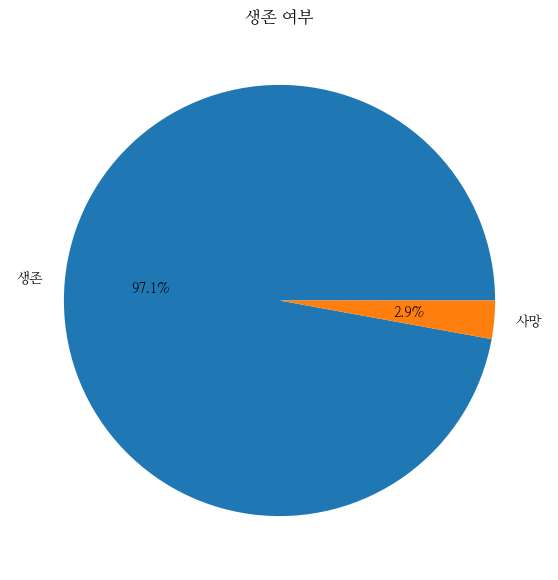

In [49]:
die = df_data['hospital_expire_flag'].value_counts()

fig= plt.figure(figsize=(7,7))
label = ['생존','사망']
die.plot.pie(labels=label,autopct='%.1f%%')
plt.title('생존 여부')
plt.ylabel('')

## 나이 분포

Text(0, 0.5, '')

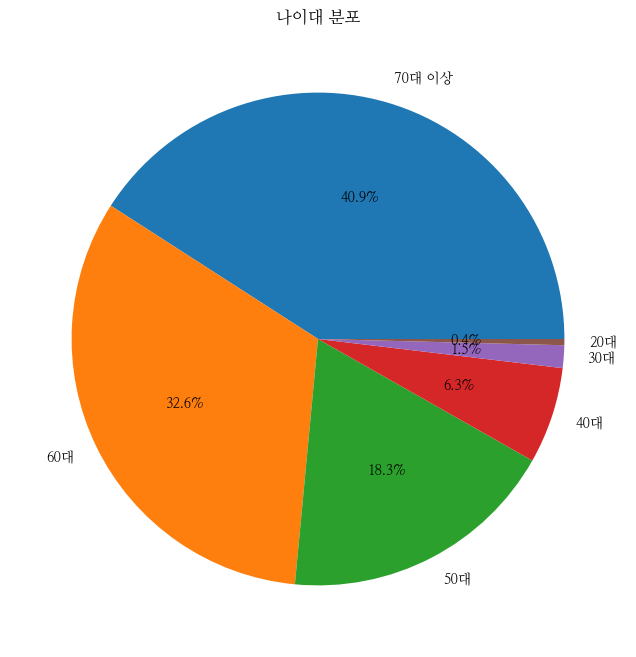

In [50]:
def age_group(age):
    if age < 20:
        return '10s'
    elif age < 30:
        return '20s'
    elif age < 40:
        return '30s'
    elif age < 50:
        return '40s'
    elif age < 60:
        return '50s'
    elif age < 70:
        return '60s'
    else:
        return '70s+'
    
df_data['age_group'] = df_data['admit_age'].apply(age_group)
sr_age = df_data['age_group'].value_counts()

plt.figure(figsize=(8, 8))
labels = ['70대 이상 ','60대','50대','40대','30대','20대']
sr_age.plot.pie(labels = labels, autopct='%1.1f%%')
plt.title('나이대 분포')
plt.ylabel('')

### 나이에 따른 사망률

In [51]:
df_data['age_group']

0       70s+
1       70s+
2       70s+
3       70s+
4        60s
        ... 
6936     60s
6937    70s+
6938    70s+
6939    70s+
6940     50s
Name: age_group, Length: 6941, dtype: object

In [52]:
df_data['hospital_expire_flag'] = df_data['hospital_expire_flag'].astype(int)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '30'),
  Text(1, 0, '20'),
  Text(2, 0, '70'),
  Text(3, 0, '60'),
  Text(4, 0, '50'),
  Text(5, 0, '40')])

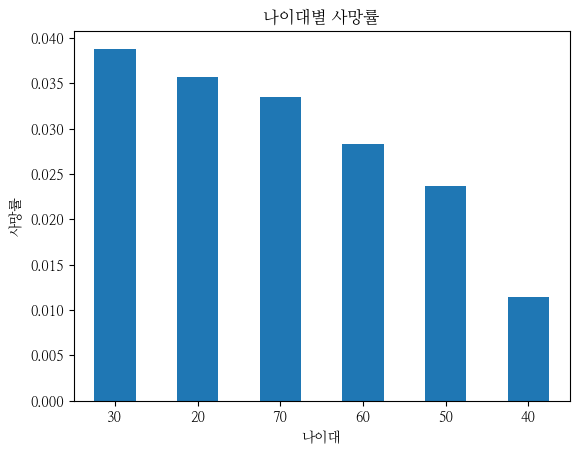

In [108]:
list_age = list(zip([70,60,50,40,30,20],survival_ratio))
sorted_list_age = sorted(list_age,key=lambda x: x[1], reverse=True)
sorted_list_age
series_data = pd.Series(dict(sorted_list_age))
series_data.plot.bar()
plt.title('나이대별 사망률')
plt.ylabel('사망률')
plt.xlabel('나이대')
plt.xticks(rotation= 0)

In [ ]:
# contingency_table = pd.crosstab(df_data['age_group'], df_data['hospital_expire_flag'])
# chi2, p, _, _ = chi2_contingency(contingency_table)

# print(f"Chi-square statistic: {chi2}")
# print(f"P-value: {p}")

# if p < 0.05:
#     print("유의미한 차이가 있습니다. 대립 가설을 채택합니다.")
# else:
#     print("유의미한 차이가 없습니다. 귀무 가설을 채택합니다.")

### 구간별 나이에 따른 사망률 및 유의성

## 성별 분포 


Text(0, 0.5, '')

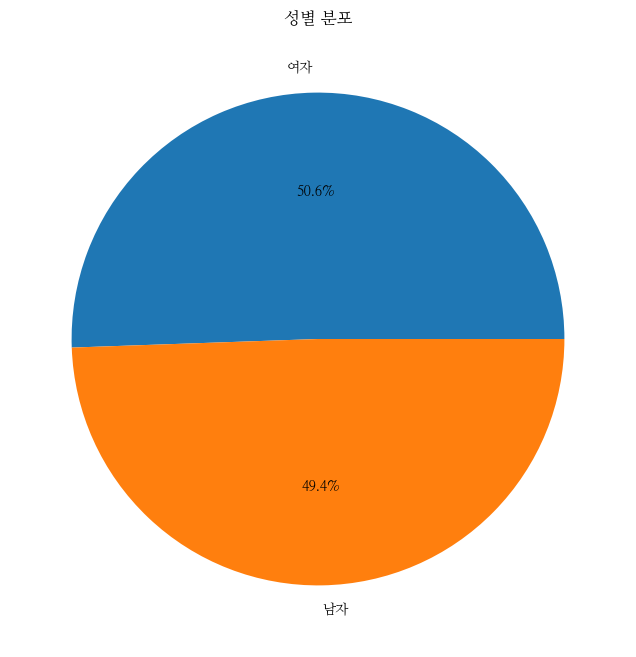

In [58]:
sr_gender = df_data['gender'].value_counts()
labels = ['여자','남자']

plt.figure(figsize=(8, 8))
sr_gender.plot.pie(labels=labels,autopct = '%1.1f%%')
plt.title('성별 분포')
plt.ylabel('')

### 성별에 따른 사망자률

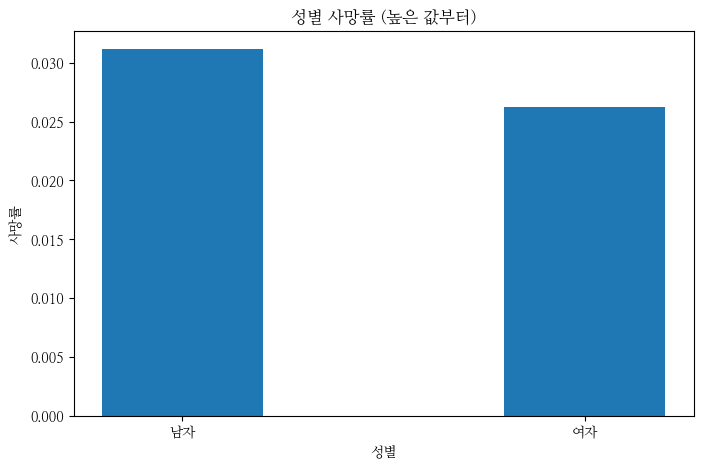

In [110]:
# Calculate survival ratio for each gender
gender_survival_ratio = []
for gender in df_data['gender'].unique():
    survival_rate = df_data.loc[df_data['gender'] == gender, 'hospital_expire_flag'].mean()
    gender_survival_ratio.append(survival_rate)

# Combine genders and survival ratios, then sort by survival ratio
gender_survival_ratio_sorted = sorted(zip(df_data['gender'].unique(), gender_survival_ratio), key=lambda x: x[1], reverse=True)

# Extract sorted genders and survival ratios
genders_sorted, survival_ratios_sorted = zip(*gender_survival_ratio_sorted)

# Map 'F' and 'M' to '여자' and '남자'
genders_sorted = ['여자' if gender == 'F' else '남자' for gender in genders_sorted]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(genders_sorted, survival_ratios_sorted, color='#1f77b4', width=0.4)
plt.title('성별 사망률 (높은 값부터)')
plt.ylabel('사망률')
plt.xlabel('성별')

plt.show()

## BMI에 따른 사망자수


(array([0, 1, 2, 3]),
 [Text(0, 0, '비만'), Text(1, 0, '정상'), Text(2, 0, '과체중'), Text(3, 0, '저체중')])

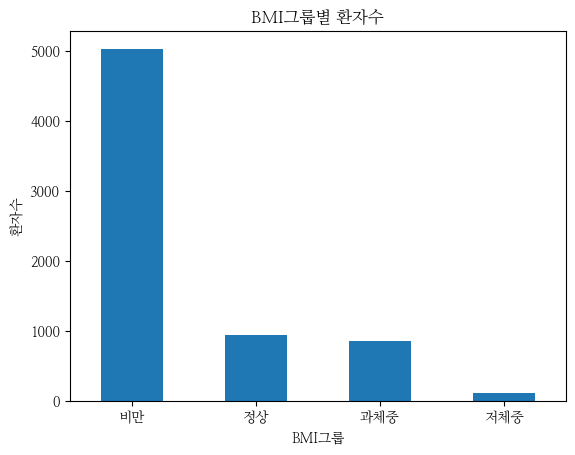

In [118]:
def f_bmi(bmi):
    if bmi<18.5:
        return '저체중'
    elif bmi<23:
        return '정상'
    elif bmi <25.00 :
        return '과체중'
    else : 
        return '비만'
    
df_data['bmi_category'] = df_data['BMI (kg/m2)'].apply(f_bmi)
sr_bmi = df_data['bmi_category'].value_counts()
sr_bmi.plot.bar()
plt.title('BMI그룹별 환자수')
plt.ylabel('환자수')
plt.xlabel('BMI그룹')
plt.xticks(rotation= 0)

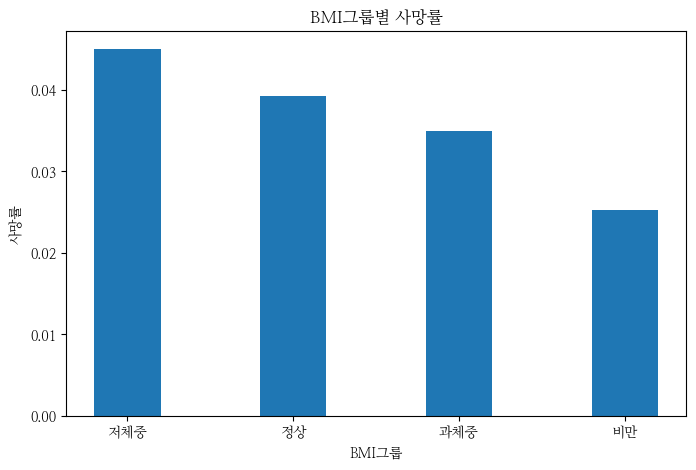

In [62]:
# Calculate survival ratio for each BMI category
bmi_survival_ratio = []
for bmi in df_data['bmi_category'].unique():
    survival_rate = df_data.loc[df_data['bmi_category'] == bmi, 'hospital_expire_flag'].mean()
    bmi_survival_ratio.append((bmi, survival_rate))

# Sort by survival ratio
bmi_survival_ratio_sorted = sorted(bmi_survival_ratio, key=lambda x: x[1], reverse=True)

# Separate the sorted data into two lists
categories_sorted, survival_ratios_sorted = zip(*bmi_survival_ratio_sorted)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories_sorted, survival_ratios_sorted, color='#1f77b4', width=0.4)
plt.title('BMI그룹별 사망률')
plt.ylabel('사망률')
plt.xlabel('BMI그룹')
plt.show()

### 구간별 BMI에 따른 사망률 및 유의성

## 체내 칼륨과 나트륨농도

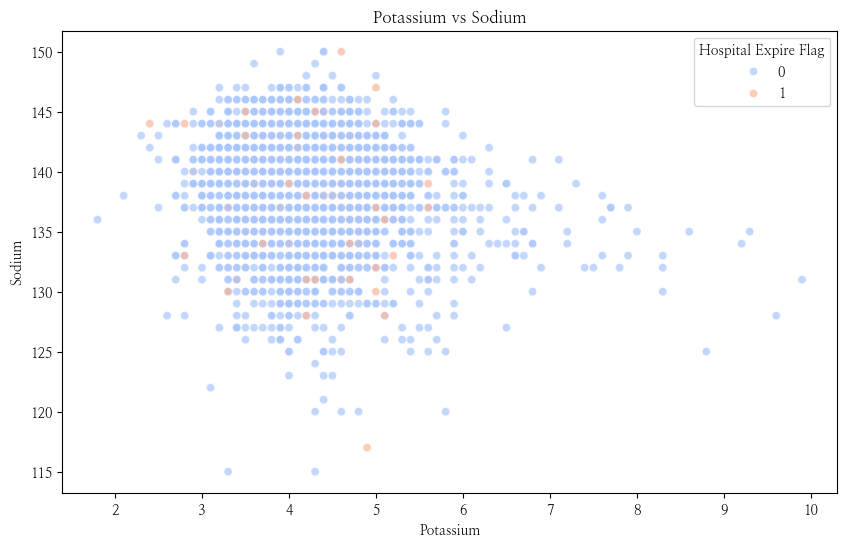

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='valuenum_Potassium', y='valuenum_Sodium', hue='hospital_expire_flag', data=df_data, palette='coolwarm', alpha=0.7)
plt.title('Potassium vs Sodium')
plt.xlabel('Potassium')
plt.ylabel('Sodium')
plt.legend(title='Hospital Expire Flag')
plt.show()


### 구간별 칼륨과 나트륨 농도 및 유의성

(array([0, 1, 2]), [Text(0, 0, '정상'), Text(1, 0, '낮음'), Text(2, 0, '높음')])

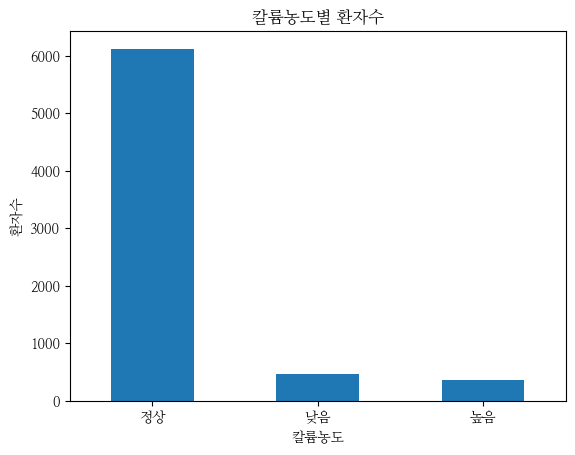

In [119]:
def f_potassium(potassium):
    if potassium<3.5:
        return '낮음'
    elif potassium<=5.1:
        return '정상'
    return '높음'


df_data['potassium_category'] = df_data['valuenum_Potassium'].apply(f_potassium)
sr_potassium = df_data['potassium_category'].value_counts()
sr_potassium.plot.bar(color = '#1f77b4')
plt.title('칼륨농도별 환자수')
plt.ylabel('환자수')
plt.xlabel('칼륨농도')
plt.xticks(rotation= 0)

<Figure size 800x500 with 0 Axes>

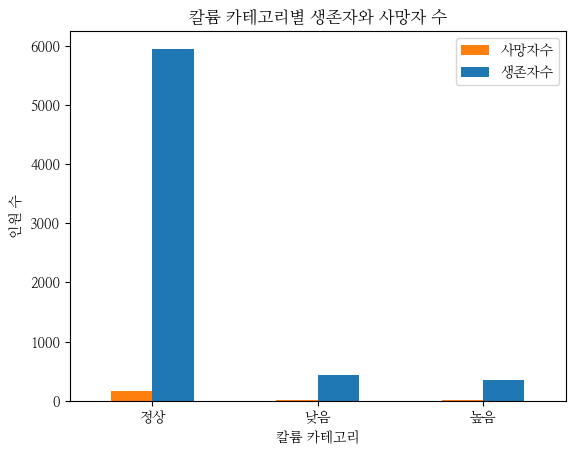

In [66]:
# Calculate number of survivors and deaths by potassium category
m_die = df_data.groupby('potassium_category')['hospital_expire_flag'].sum()
m_surv = df_data.groupby('potassium_category')['hospital_expire_flag'].count() - m_die

# Concatenate and create DataFrame
mg = pd.concat([m_die, m_surv], axis=1)
mg.columns = ['사망자수', '생존자수']

# Sort by number of deaths
mg = mg.sort_values(by='사망자수', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 5))
mg.plot.bar(color=['#ff7f0e', '#1f77b4'])
plt.title('칼륨 카테고리별 생존자와 사망자 수')
plt.ylabel('인원 수')
plt.xlabel('칼륨 카테고리')
plt.xticks(rotation=0)  # x축 레이블 회전 없음
plt.legend(loc='upper right')
plt.show()

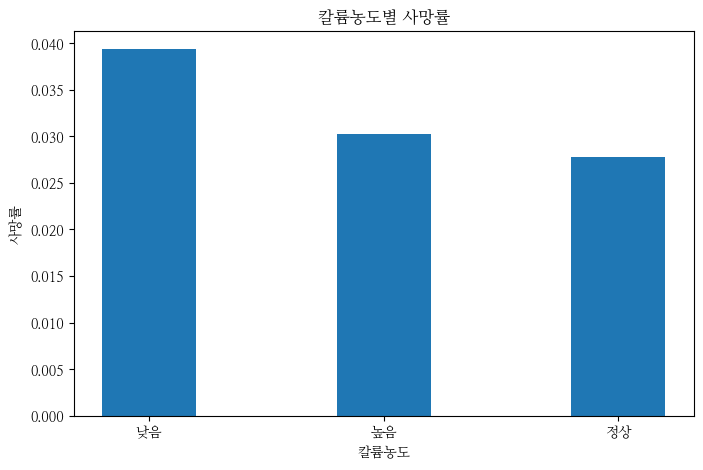

In [68]:
# Calculate survival ratio for each potassium category
potassium_survival_ratio = []
for potassium in df_data['potassium_category'].unique():
    survival_rate = df_data.loc[df_data['potassium_category'] == potassium, 'hospital_expire_flag'].mean()
    potassium_survival_ratio.append(survival_rate)

# Sort categories by survival ratio
potassium_categories = df_data['potassium_category'].unique()
potassium_survival_ratio_sorted = sorted(zip(potassium_categories, potassium_survival_ratio), key=lambda x: x[1], reverse=True)

# Extract sorted categories and survival ratios
categories_sorted, survival_ratios_sorted = zip(*potassium_survival_ratio_sorted)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories_sorted, survival_ratios_sorted, color='#1f77b4', width=0.4)
plt.title('칼륨농도별 사망률')
plt.ylabel('사망률')
plt.xlabel('칼륨농도')
plt.xticks(rotation=0)  # x축 레이블 회전 없음
plt.show()

# 나트륨농도

(array([0, 1, 2]), [Text(0, 0, '정상'), Text(1, 0, '낮음'), Text(2, 0, '높음')])

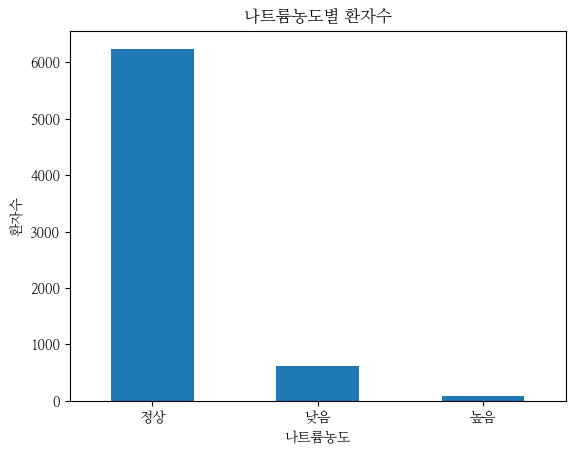

In [120]:
def f_sodium(sodium):
    if sodium<135:
        return '낮음'
    elif sodium<=145:
        return '정상'
    return '높음'


df_data['sodium_category'] = df_data['valuenum_Sodium'].apply(f_sodium)
sr_sodium = df_data['sodium_category'].value_counts()
sr_sodium.plot.bar(color = '#1f77b4')
plt.title('나트륨농도별 환자수')
plt.ylabel('환자수')
plt.xlabel('나트륨농도')
plt.xticks(rotation= 0)

<Figure size 800x500 with 0 Axes>

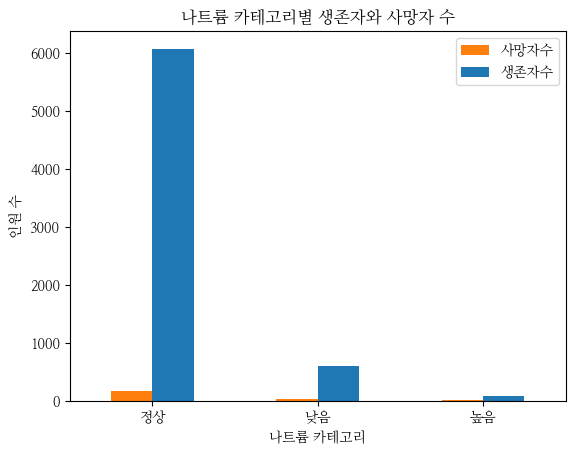

In [73]:
#Calculate number of survivors and deaths by sodium category
m_die = df_data.groupby('sodium_category')['hospital_expire_flag'].sum()
m_surv = df_data.groupby('sodium_category')['hospital_expire_flag'].count() - m_die

# Concatenate and create DataFrame
mg = pd.concat([m_die, m_surv], axis=1)
mg.columns = ['사망자수', '생존자수']

# Sort by number of deaths
mg = mg.sort_values(by='사망자수', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 5))
mg.plot.bar(color=['#ff7f0e', '#1f77b4'])
plt.title('나트륨 카테고리별 생존자와 사망자 수')
plt.ylabel('인원 수')
plt.xlabel('나트륨 카테고리')
plt.xticks(rotation=0)  # x축 레이블 회전 없음
plt.legend(loc='upper right')
plt.show()

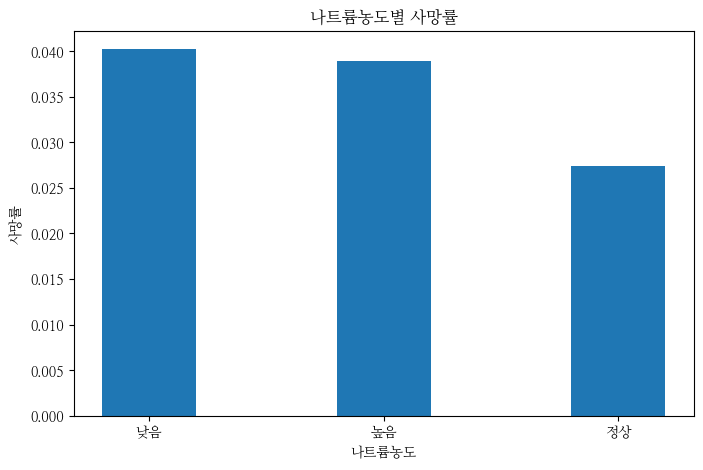

In [71]:
sodium_survival_ratio = []
for sodium in df_data['sodium_category'].unique():
    survival_rate = df_data.loc[df_data['sodium_category'] == sodium, 'hospital_expire_flag'].mean()
    sodium_survival_ratio.append((sodium, survival_rate))


sodium_survival_ratio_sorted = sorted(sodium_survival_ratio, key=lambda x: x[1], reverse=True)


categories_sorted, survival_ratios_sorted = zip(*sodium_survival_ratio_sorted)


plt.figure(figsize=(8, 5))
plt.bar(categories_sorted, survival_ratios_sorted, color='#1f77b4', width=0.4)
plt.title('나트륨농도별 사망률')
plt.ylabel('사망률')
plt.xlabel('나트륨농도')
plt.show()

## 혈압분포

### 수축기와 이완기에 따른 사망자,생존자 분포

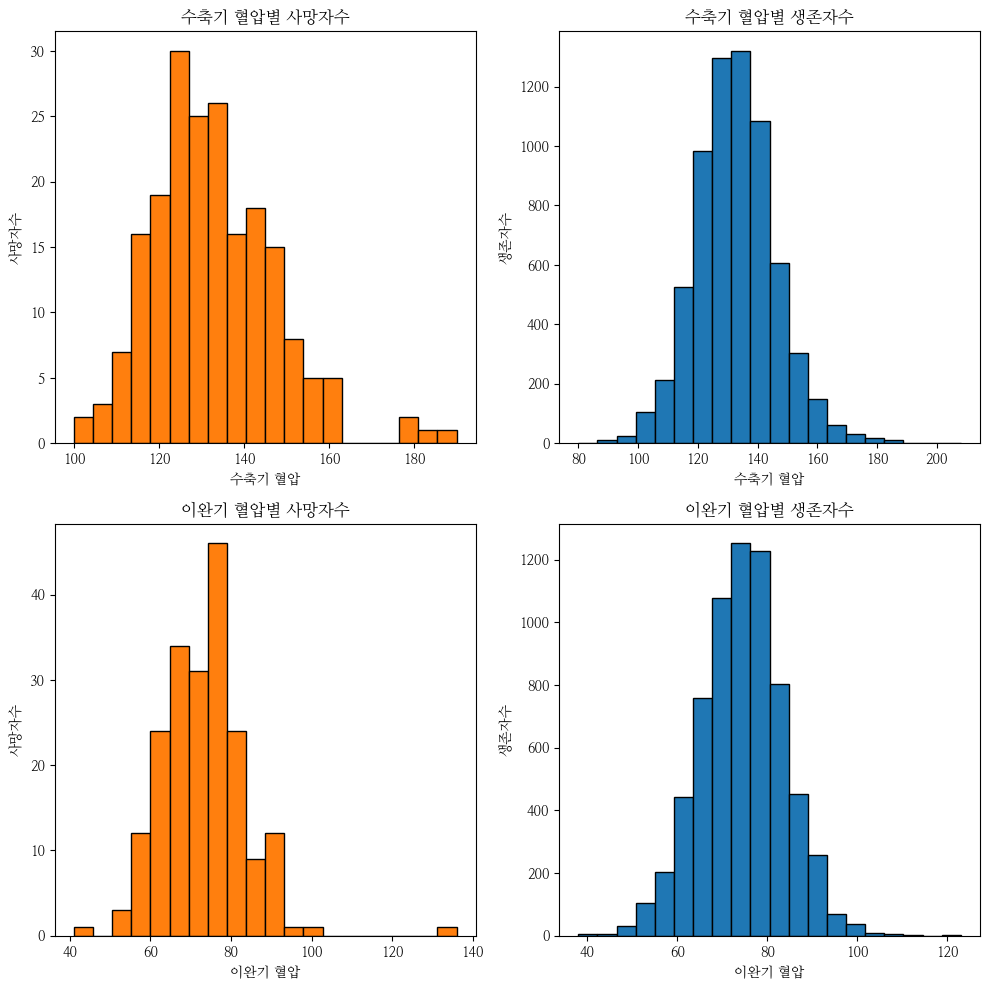

In [74]:
fig = plt.figure(figsize = (10,10))
axs  = fig.subplots(2,2).flatten()

#============ax0=============================================================#
sr_sy_die = df_data.loc[df_data['hospital_expire_flag']==1,'Systolic']
sr_sy_die.plot.hist(bins = 20,edgecolor = 'black',ax = axs[0], color ='#ff7f0e')
axs[0].title.set_text("수축기 혈압별 사망자수")
axs[0].set_ylabel('사망자수')
axs[0].set_xlabel('수축기 혈압')

#============ax1=============================================================#
sr_sy_surv = df_data.loc[df_data['hospital_expire_flag']==0,'Systolic']
sr_sy_surv.plot.hist(bins = 20,edgecolor = 'black',ax=axs[1])
axs[1].title.set_text("수축기 혈압별 생존자수")
axs[1].set_ylabel('생존자수')
axs[1].set_xlabel('수축기 혈압')


#============ax2=============================================================#
sr_dia_die = df_data.loc[df_data['hospital_expire_flag']==1,'Diastolic']
sr_dia_die.plot.hist(bins = 20,edgecolor = 'black',ax = axs[2],color ='#ff7f0e')
axs[2].title.set_text("이완기 혈압별 사망자수")
axs[2].set_ylabel('사망자수')
axs[2].set_xlabel('이완기 혈압')

#============ax3=============================================================#
sr_dia_surv = df_data.loc[df_data['hospital_expire_flag']==0,'Diastolic']
sr_dia_surv.plot.hist(bins = 20,edgecolor = 'black',ax=axs[3] )
axs[3].title.set_text("이완기 혈압별 생존자수")
axs[3].set_ylabel('생존자수')
axs[3].set_xlabel('이완기 혈압')
fig.tight_layout()

# prescriptions파일 추가

In [76]:
presc = pd.read_csv('prescriptions.csv', usecols=['subject_id', 'drug'])

df_drug = pd.merge(df_data,presc,on='subject_id')

df_drug['drug'].value_counts()

0.9% Sodium Chloride           66293
Insulin                        60325
Potassium Chloride             48795
Sodium Chloride 0.9%  Flush    47991
Acetaminophen                  39841
                               ...  
Ergocalciferol (Vitamin D2)        1
Dacomitinib                        1
REVLIMID Lenalidomide              1
adalimumab                         1
Rimantadine                        1
Name: drug, Length: 3365, dtype: int64

In [77]:
# drug 열을 범주형으로 변환
df_drug['drug'] = df_drug['drug'].astype('category')

# 범주별 사망 비율 계산
death_rates = df_drug.groupby('drug')['hospital_expire_flag'].mean()

death_rates.sort_values(ascending=False)

drug
Biktarvy (bictegravir-emtricit-tenofovir)    1.0
Trileptal                                    1.0
Jadenu                                       1.0
Omeprazole Magnesium                         1.0
INV-enoxaparin                               1.0
                                            ... 
Isavuconazonium sulfate                      0.0
Isosorbid                                    0.0
Isosorbide                                   0.0
Isosorbide                                   0.0
zz                                           0.0
Name: hospital_expire_flag, Length: 3365, dtype: float64

# pharmacy 파일 추가

In [81]:
pmc = pd.read_csv('pharmacy.csv', usecols=['subject_id','medication','frequency'])
pmc_merge = pd.merge(df_data,pmc,on='subject_id')

# 빈도 상위 10개 약물

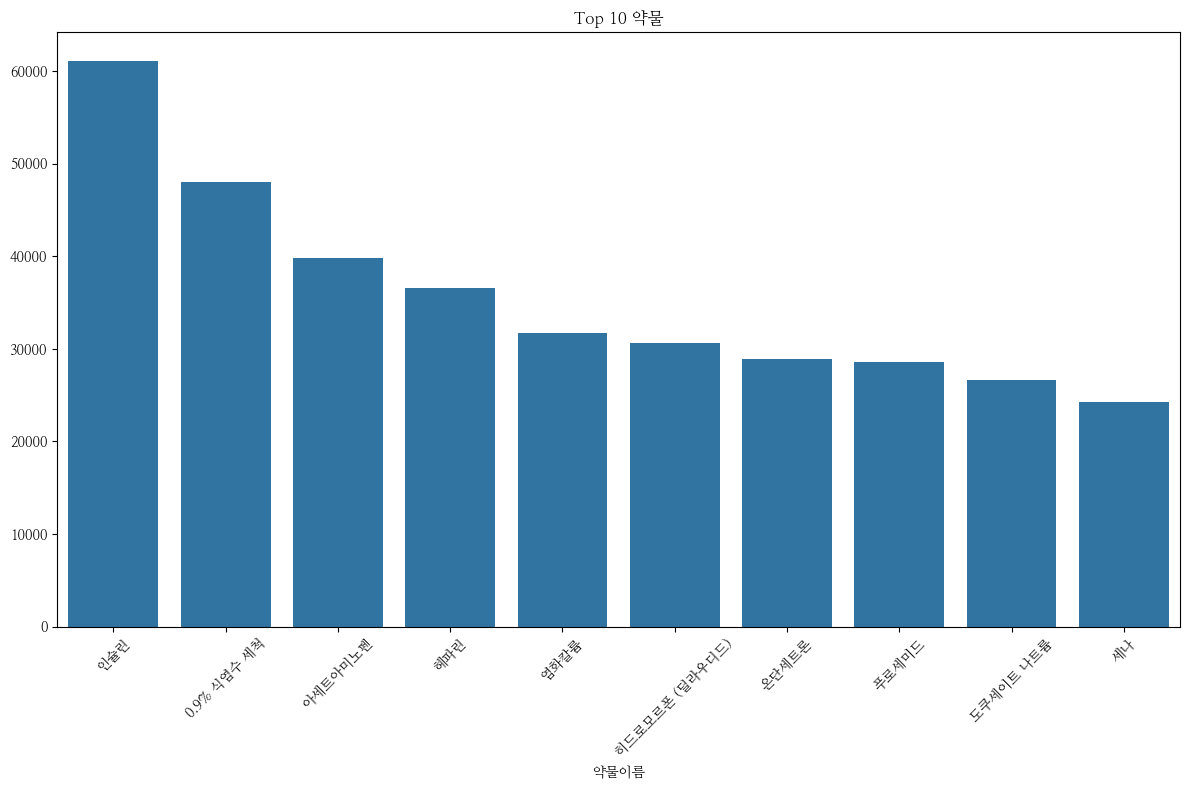

In [135]:
# 약물별 사용 빈도 계산
medication_counts = df['medication'].value_counts().nlargest(10)  # 상위 10개 약물

# 원하는 라벨 지정
x_axis_labels = [
    "인슐린",
    "0.9% 식염수 세척",
    "아세트아미노펜",
    "헤파린",
    "염화칼륨",
    "히드로모르폰 (딜라우디드)",
    "온단세트론",
    "푸로세미드",
    "도쿠세이트 나트륨",
    "세나",
]

# 막대 그래프로 시각화
plt.figure(figsize=(12, 8))
sns.barplot(y=medication_counts.values, x=medication_counts.index, color='#1f77b4')
plt.title('Top 10 약물')
plt.xlabel('약물이름')
plt.ylabel('')

# x축 라벨을 지정된 한글 라벨로 변경
plt.xticks(range(len(x_axis_labels)), x_axis_labels,rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
x_axis_labels = [
    "인슐린",
    "0.9% 식염수 세척",
    "아세트아미노펜",
    "헤파린",
    "염화칼륨",
    "히드로모르폰 (딜라우디드)",
    "온단세트론",
    "푸로세미드",
    "도쿠세이트 나트륨",
    "세나",
]

# 약물 투여빈도별 사망률


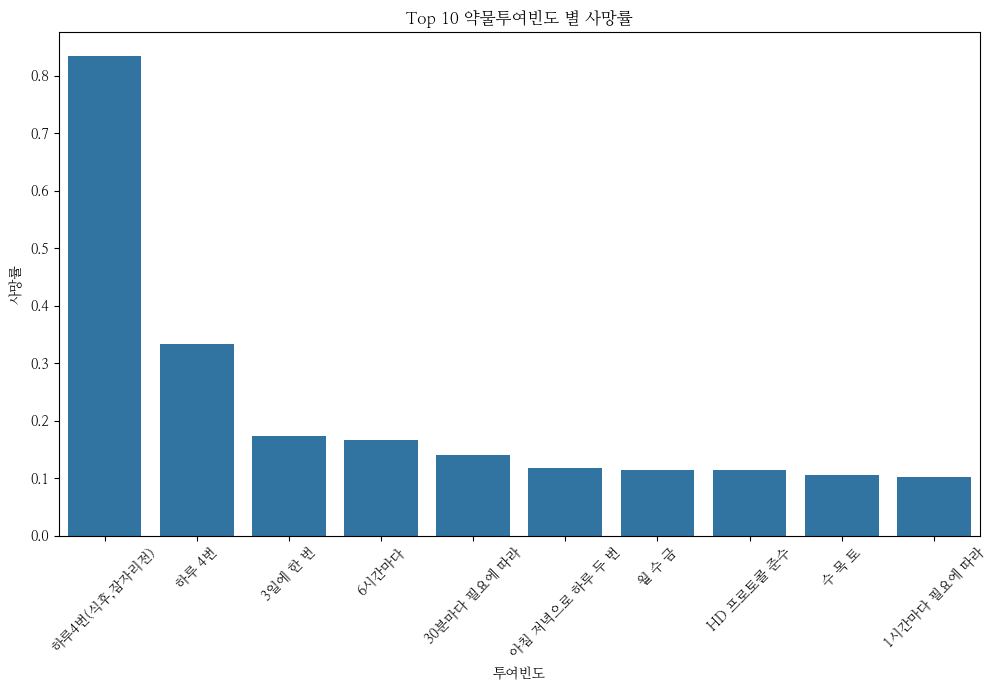

In [129]:
df = pmc_merge

# 빈도별 사망률 계산
death_rates_by_frequency = df.groupby('frequency')['hospital_expire_flag'].mean().reset_index()

# 사망률 기준으로 내림차순 정렬 후 상위 10개 선택
death_rates_top10 = death_rates_by_frequency.sort_values(by='hospital_expire_flag', ascending=False).head(10)

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='hospital_expire_flag', data=death_rates_top10,  color='#1f77b4')
plt.title('Top 10 약물투여빈도 별 사망률')
plt.xlabel('투여빈도')
plt.ylabel('사망률')
plt.tight_layout()
custom_labels = ['하루4번(식후,잠자리전)','하루 4번', '3일에 한 번', '6시간마다', '30분마다 필요에 따라', 
                 '아침 저녁으로 하루 두 번', '월 수 금', 'HD 프로토콜 준수', 
                 '수 목 토', '1시간마다 필요에 따라']
plt.xticks(range(len(custom_labels)), custom_labels, rotation=45)
plt.show()